In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs

from graph_generator.community_graph import make_random_signed_graph, connect_communities
from helpers import signed_layout, draw_nodes, draw_edges


In [3]:
def make_polarized_graphs(
    k, comm_sizes,
    internal_density=0.9,
    internal_neg_ratio=0.05,
    comm_cross_edge_proba=0.5,
    comm_cross_neg_ratio=0.95,
    cross_edge_proba=0.01,
    cross_neg_ratio=0.5
):
    print('#communities', k)
    assert k == len(comm_sizes)
    comms = []
    for i, sizes in zip(range(k), comm_sizes):
        assert len(sizes) == 2
        n1, n2 = sizes
        c0 = make_random_signed_graph(n1, internal_density, internal_neg_ratio)
        c1 = make_random_signed_graph(n2, internal_density, internal_neg_ratio)
        c, _ = connect_communities([c0, c1], edge_proba=comm_cross_edge_proba, neg_ratio=comm_cross_neg_ratio)
        print('comm#{} sizes: {} {}'.format(i+1, c0.number_of_nodes(), c1.number_of_nodes()))
        comms.append(c)

    g, _ = connect_communities(comms, edge_proba=cross_edge_proba, neg_ratio=cross_neg_ratio)
    return g

In [108]:
size = 10
g = make_polarized_graphs(2, [(size, size), (size, size)])

#communities 2
comm#1 sizes: 10 10
comm#2 sizes: 10 10


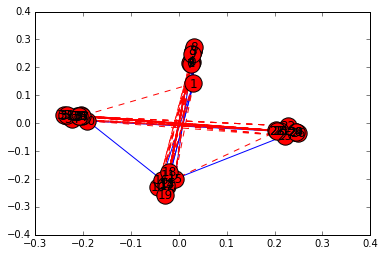

In [111]:
pos = signed_layout(g)
draw_nodes(g, pos)
draw_edges(g, pos)

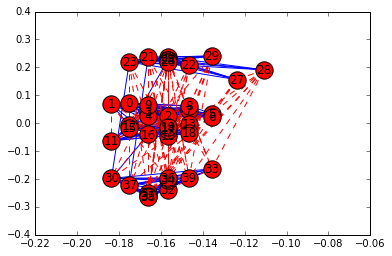

In [110]:
from helpers import pos_adj, neg_adj, normalized_laplacian
from scipy.linalg import sqrtm, inv

# visualization using geometric mean of Laplacian
# Reference: 
# Clustering Signed Networks with the Geometric Mean of Laplacians, NIPS 2016
# note: supporting only **small** graphs (internally using numpy.array)

A = nx.adjacency_matrix(g, weight='sign')
Ap = pos_adj(A).A
An = neg_adj(A).A
Lp = normalized_laplacian(Ap).A
Qn = normalized_laplacian(An, subtract=False).A

Lp_sq = sqrtm(Lp)
Lp_sq_inv = inv(Lp_sq)
L_gm = Lp_sq @ sqrtm(Lp_sq_inv @ Qn @ Lp_sq_inv) @ Lp_sq

w, pos_array = eigs(np.real(L_gm), k=2, which='SM')
pos_array = np.real(pos_array)
pos = {i: pos_array[i, :] for i in range(g.number_of_nodes())}

# draw
draw_nodes(g, pos)
draw_edges(g, pos)

In [112]:
from scipy.sparse import diags

def degree_diag(g):
    deg = nx.adjacency_matrix(g).sum(axis=0)
    return diags(deg.tolist()[0], 0)
    

In [113]:
def prepare_seed_vector(seeds, D):
    """prepare seed vector s s.t. 
       s.T D s = 1
    """
    n = D.shape[0]
    s = np.zeros(n)

    for u in seeds[0]:
        s[u] = 1
    for u in seeds[1]:
        s[u] = -1
    s /= np.linalg.norm(s)
    s = s[:, None]

    s = np.diag(1 / np.sqrt(D.diagonal())) @ s
    
    # requirement check 
    sTDs = (s.T @ D @ s)
    assert np.isclose(sTDs[0, 0], 1.0), '{} != 0.0'.format(sTDs[0, 0])
    
    return s

In [119]:
# solve the SDP program

import cvxpy as cp
from helpers import signed_laplacian

kappa = 0.25
comm = 0
seeds = [[comm * 2 * size], [(comm * 2 + 1) * size]]

n = g.number_of_nodes()
L = signed_laplacian(g).A
D = degree_diag(g).A

s = prepare_seed_vector(seeds, D)

# requirement check 
_, v1 = eigs(np.real(L), k=1, which='SM')
assert not np.isclose((s.T @ np.real(v1))[0, 0], 0)

DsDsT = (D @ s) @ (D @ s).T

X = cp.Variable((n, n))
constraints = [
    X >> 0,
    cp.trace(D @ X) == 1,
    cp.trace(DsDsT @ X) >= kappa
]
prob = cp.Problem(cp.Minimize(cp.trace(L @ X)), constraints)
prob.solve()


WARN: m less than n, problem likely degenerate


0.16290253211426844

In [120]:
def is_rank_one(M, verbose=False):
    """
    we check if the ith row/col are a multiple of the jth row/column
    
    before doing that, we round the numbers to certain decimal point
    
    note thatfor some unknown reason, the following does not return 1
    
    np.linalg.matrix_rank(np.round(X.value, 3))
    """
    n = M.shape[0]
    r = 0
    for i in range(n):
        for j in range(i+1, n):
            divisors = M[i, :] / M[j, :]
            divisors = np.round(divisors, 3)
            r = max(r, len(np.unique(divisors)))
            if verbose:
                print(np.unique(divisors))
    if r > 1:
        print('rank is {}'.format(r))
    return r == 1

In [121]:
print("is rank one? ", is_rank_one(X.value, False))
x_opt = X.value[0, :]

is rank one?  True


In [122]:
for i in range(4):
    print(x_opt[i*size:(i+1)*size])

[0.00832815 0.00349852 0.00462685 0.00541994 0.00471995 0.00540677
 0.0043059  0.00491074 0.00600158 0.00557324]
[-0.00895144 -0.00412416 -0.00481828 -0.00481783 -0.00495701 -0.0040255
 -0.00447731 -0.00500846 -0.00409395 -0.00537383]
[0.00164964 0.00149345 0.00225303 0.00141761 0.00169629 0.00121755
 0.00166963 0.0013861  0.00135927 0.00164527]
[-0.00160166 -0.0016702  -0.0015283  -0.00134841 -0.00179753 -0.00163952
 -0.00146834 -0.00142417 -0.00161315 -0.00143792]


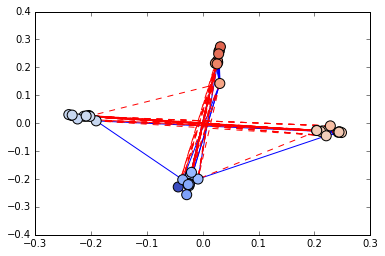

In [123]:
from matplotlib import pyplot as plt

nx.draw_networkx_nodes(g, pos, node_size=100, node_color=x_opt, cmap=plt.cm.coolwarm)
# draw_nodes(g, pos)
draw_edges(g, pos)